#  Exploratory Regression models

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Parameters
segment_results = 'Y'  # Set to 'Y' to segment results by a specific column or 'N' to run the model on the entire dataset
segmentation_column = 'Generation'  # The column used for segmentation
filter_column = None  # The column used for filtering
filter_values = None  # List of values to exclude from the dataset
pvalue_threshold = 0.05  # P-value threshold for significance
y_column = 'Yvar_USE_AI_Work'  # Dependent variable
x_column_prefix = 'VAR'  # Prefix for independent variables
output_filename_template = 'Regression_Results_{segmentation_column}_Detailed.xlsx'  # Template for output filename

# Define the path to your dataset
current_directory = os.path.dirname(os.getcwd())
print(current_directory)

excel_path = os.path.join(current_directory, '01-data', 'TAM_DEF.xlsx')
summary_dir = os.path.join(current_directory, '04-summary')
print(excel_path)

# Ensure the summary directory exists
if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

# Load the dataset
try:
    df = pd.read_excel(excel_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please check the file path: {excel_path}")
    exit()
except Exception as e:
    print(f"Error during dataset loading: {e}")
    exit()

# Apply filtering if filter_column and filter_values are set
if filter_column and filter_values:
    df = df[~df[filter_column].isin(filter_values)]
    print(f"Filtered dataset to exclude {filter_values} in {filter_column}")

if segment_results == 'Y':
    # Get unique values in the segmentation column
    segments = df[segmentation_column].unique()
    print(f"Found {segmentation_column} segments: {segments}")
else:
    # If not segmenting, treat the entire dataset as a single segment
    segments = ['Entire Dataset']
    df['Entire Dataset'] = 'Entire Dataset'  # Add a dummy column to facilitate the loop

# Loop through each segment and run the regression model
all_results = []
top_variables_set = set()

for segment in segments:
    df_segment = df[df[segmentation_column] == segment] if segment != 'Entire Dataset' else df
    
    # Define X (independent variables) and y (dependent variable)
    X = df_segment.filter(regex=f'^{x_column_prefix}')
    y = df_segment[y_column]
    
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Extract the results, filtering by p-value threshold
    significant_results = model.summary2().tables[1]
    significant_results = significant_results[significant_results['P>|t|'] <= pvalue_threshold]
    
    # Exclude the constant from the top variables set
    top_variables_set.update(var for var in significant_results.index.tolist() if var != 'const')
    
    # Append results to the list for later export
    segment_results = significant_results.reset_index()
    segment_results.insert(0, 'Segment', segment)
    segment_results.insert(1, 'R2 Value', model.rsquared)
    all_results.append(segment_results)

# Combine the results from all segments into a DataFrame
all_results_df = pd.concat(all_results)

# Run overall regression with combined top variables
combined_X = df[list(top_variables_set)]
combined_X = sm.add_constant(combined_X)
combined_model = sm.OLS(df[y_column], combined_X).fit()

# Prepare overall model results for export
overall_results = combined_model.summary2().tables[1].reset_index()
overall_results.insert(0, 'Segment', 'Overall')
overall_results.insert(1, 'R2 Value', combined_model.rsquared)

# Save the results to Excel, including the segmentation column name in the filename
output_filename = output_filename_template.format(segmentation_column=segmentation_column)
output_path = os.path.join(summary_dir, output_filename)

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    # Write the overall hypothesis results
    all_results_df.to_excel(writer, sheet_name='Hypothesis Results', index=False)
    
    # Write the overall regression results
    overall_results.to_excel(writer, sheet_name='Overall Regression', index=False)

    # Apply formatting
    workbook = writer.book
    header_format = workbook.add_format({
        'bold': True, 'text_wrap': True, 'align': 'center', 'valign': 'center', 'bg_color': '#D9EAD3'
    })
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.set_row(0, None, header_format)
        worksheet.set_column('A:G', 20)  # Adjust column width for better readability

    print(f"Summary statistics and regression results saved to {output_path}.")

/Users/danramirez/mbs-structural-equation-modeling
/Users/danramirez/mbs-structural-equation-modeling/01-data/TAM_DEF.xlsx
Dataset loaded successfully.
Found Generation segments: ['Boomer' 'Gen Z' 'Gen X' 'Millennial']
Summary statistics and regression results saved to /Users/danramirez/mbs-structural-equation-modeling/04-summary/Regression_Results_Generation_Detailed.xlsx.


# Custom X variable List— Exploratory Regresson Models

In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Parameters
segment_results = 'Y'  # Set to 'Y' to segment results by a specific column or 'N' to run the model on the entire dataset
segmentation_column = 'Generation'  # The column used for segmentation
filter_column = None  # The column used for filtering
filter_values = None  # List of values to exclude from the dataset
pvalue_threshold = 0.1  # P-value threshold for significance
y_column = 'Yvar_USE_AI_Work'  # Dependent variable
x_column_prefixes = ['VAR07_JOB_Postive_Import',
'VAR08_JOB_Enchance_Job_Security',
'VAR09_WORKFORCE_AI_Job_loss',
'VAR10_WORKFORCE_AI_Increase_Opportunity_Growth',
'VAR14_SAFETY_AI_Need_Protocols',
'VAR15_SAFETY_AI_protect_Cyber_Threats']  # List of prefixes for independent variables
output_filename_template = 'Regression_Results_{segmentation_column}_Detailed.xlsx'  # Template for output filename

# Define the path to your dataset
current_directory = os.path.dirname(os.getcwd())
print(current_directory)

excel_path = os.path.join(current_directory, '01-data', 'TAM_DEF.xlsx')
summary_dir = os.path.join(current_directory, '04-summary')

# Ensure the summary directory exists
if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

# Load the dataset
try:
    df = pd.read_excel(excel_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found. Please check the file path: {excel_path}")
    exit()
except Exception as e:
    print(f"Error during dataset loading: {e}")
    exit()

# Apply filtering if filter_column and filter_values are set
if filter_column and filter_values:
    df = df[~df[filter_column].isin(filter_values)]
    print(f"Filtered dataset to exclude {filter_values} in {filter_column}")

if segment_results == 'Y':
    # Get unique values in the segmentation column
    segments = df[segmentation_column].unique()
    print(f"Found {segmentation_column} segments: {segments}")
else:
    # If not segmenting, treat the entire dataset as a single segment
    segments = ['Entire Dataset']
    df['Entire Dataset'] = 'Entire Dataset'  # Add a dummy column to facilitate the loop

# Loop through each segment and run the regression model
all_results = []
top_variables_set = set()

for segment in segments:
    df_segment = df[df[segmentation_column] == segment] if segment != 'Entire Dataset' else df
    
    # Define X (independent variables) and y (dependent variable)
    X = pd.concat([df_segment.filter(regex=f'^{prefix}') for prefix in x_column_prefixes], axis=1)
    y = df_segment[y_column]
    
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Extract the results, filtering by p-value threshold
    significant_results = model.summary2().tables[1]
    significant_results = significant_results[significant_results['P>|t|'] <= pvalue_threshold]
    
    # Exclude the constant from the top variables set
    top_variables_set.update(var for var in significant_results.index.tolist() if var != 'const')
    
    # Append results to the list for later export
    segment_results = significant_results.reset_index()
    segment_results.insert(0, 'Segment', segment)
    segment_results.insert(1, 'R2 Value', model.rsquared)
    all_results.append(segment_results)

# Combine the results from all segments into a DataFrame
all_results_df = pd.concat(all_results)

# Run overall regression with combined top variables
combined_X = df[list(top_variables_set)]
combined_X = sm.add_constant(combined_X)
combined_model = sm.OLS(df[y_column], combined_X).fit()

# Prepare overall model results for export
overall_results = combined_model.summary2().tables[1].reset_index()
overall_results.insert(0, 'Segment', 'Overall')
overall_results.insert(1, 'R2 Value', combined_model.rsquared)

# Save the results to Excel, including the segmentation column name in the filename
output_filename = output_filename_template.format(segmentation_column=segmentation_column)
output_path = os.path.join(summary_dir, output_filename)

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    # Write the overall hypothesis results
    all_results_df.to_excel(writer, sheet_name='Hypothesis Results', index=False)
    
    # Write the overall regression results
    overall_results.to_excel(writer, sheet_name='Overall Regression', index=False)

    # Apply formatting
    workbook = writer.book
    header_format = workbook.add_format({
        'bold': True, 'text_wrap': True, 'align': 'center', 'valign': 'center', 'bg_color': '#D9EAD3'
    })
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        worksheet.set_row(0, None, header_format)
        worksheet.set_column('A:G', 20)  # Adjust column width for better readability

    print(f"Summary statistics and regression results saved to {output_path}.")


/Users/danramirez/mbs-structural-equation-modeling
Dataset loaded successfully.
Found Generation segments: ['Boomer' 'Gen Z' 'Gen X' 'Millennial']
Summary statistics and regression results saved to /Users/danramirez/mbs-structural-equation-modeling/04-summary/Regression_Results_Generation_Detailed.xlsx.


# SEM

/Users/danramirez/mbs-structural-equation-modeling
Dataset loaded successfully.

Processing segment: Entire Dataset


SEM model optimized for segment: Entire Dataset


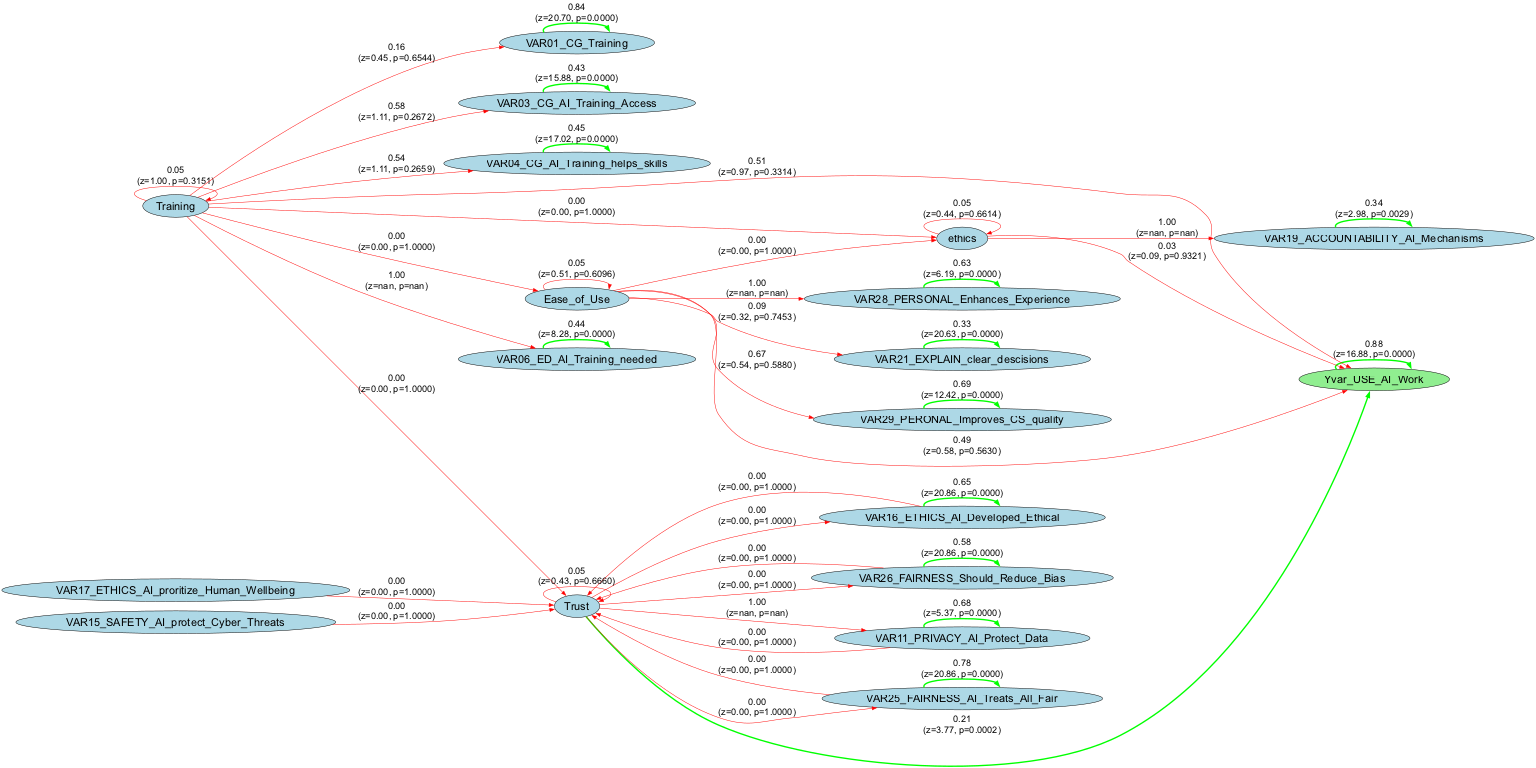

Visualization saved for segment Entire Dataset at /Users/danramirez/mbs-structural-equation-modeling/02-charts/SEM_Visualization_Entire Dataset.png

Hypotheses summary saved to /Users/danramirez/mbs-structural-equation-modeling/04-summary/SEM_Results.xlsx


In [3]:
import os
import pandas as pd
import numpy as np
from semopy import Model, Optimizer
import pydot
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Font, Alignment
from openpyxl.utils.dataframe import dataframe_to_rows
from IPython.display import Image, display

# Parameters
p_value_threshold = 0.05  # Threshold for significance
dependent_variable = 'Yvar_USE_AI_Work'  # Dependent variable
segment_results = 'N'  # 'Y' or 'N'
segmentation_column = 'Generation'  # Column for segmentation
filter_column = None  # Column for filtering
filter_values = None  # Values to exclude

# Paths
current_directory = os.path.dirname(os.getcwd())
print(current_directory)

data_dir = os.path.join(current_directory, '01-data')
summary_dir = os.path.join(current_directory, '04-summary')
charts_dir = os.path.join(current_directory, '02-charts')

# Ensure directories exist
os.makedirs(summary_dir, exist_ok=True)
os.makedirs(charts_dir, exist_ok=True)

# Load dataset
excel_path = os.path.join(data_dir, 'TAM_DEF.xlsx')
try:
    df = pd.read_excel(excel_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Dataset not found at {excel_path}")
    exit()

# Apply filtering
if filter_column and filter_values is not None:
    if not isinstance(filter_values, (list, tuple, np.ndarray)):
        filter_values = [filter_values]
    df = df[~df[filter_column].isin(filter_values)]
    print(f"Filtered out {filter_values} from {filter_column} column.")

# Segmentation setup
if segment_results.upper() == 'Y':
    segments = df[segmentation_column].unique()
    print(f"Segments identified: {segments}")
else:
    segments = ['Entire Dataset']
    df['Entire Dataset'] = 'Entire Dataset'  # Dummy column for uniform processing

# SEM Model Description
model_desc = f"""
# Latent variables
Trust =~ VAR11_PRIVACY_AI_Protect_Data + VAR16_ETHICS_AI_Developed_Ethical + VAR25_FAIRNESS_AI_Treats_All_Fair + VAR26_FAIRNESS_Should_Reduce_Bias
Ease_of_Use =~ VAR28_PERSONAL_Enhances_Experience + VAR29_PERONAL_Improves_CS_quality + VAR21_EXPLAIN_clear_descisions
Training =~ VAR06_ED_AI_Training_needed + VAR03_CG_AI_Training_Access + VAR01_CG_Training + VAR04_CG_AI_Training_helps_skills
ethics =~ VAR19_ACCOUNTABILITY_AI_Mechanisms

# Direct relationships with Usage ({dependent_variable})
{dependent_variable} ~ Trust
{dependent_variable} ~ Ease_of_Use
{dependent_variable} ~ Training
{dependent_variable} ~ ethics

# Relationships with latent variables
Trust ~ Training
Trust ~ VAR16_ETHICS_AI_Developed_Ethical
Trust ~ VAR15_SAFETY_AI_protect_Cyber_Threats
Trust ~ VAR17_ETHICS_AI_proritize_Human_Wellbeing
Trust ~ VAR11_PRIVACY_AI_Protect_Data
Trust ~ VAR25_FAIRNESS_AI_Treats_All_Fair
Trust ~ VAR26_FAIRNESS_Should_Reduce_Bias
"""

# Hypotheses definitions
hypothesis_criteria = [
    (f"Hypothesis 1: AI Training and Career Growth Opportunities Influence Ease of Use and Trust", f'{dependent_variable} ~ Training'),
    (f"Hypothesis 2: Explainability and Fairness Influence User Trust and AI Adoption", f'{dependent_variable} ~ Trust'),
    (f"Hypothesis 3: Ethical Development and Social Responsibility Influence User Use", f'{dependent_variable} ~ ethics'),
    (f"Hypothesis 4: AI-Driven Personalization Enhances User Experience", f'{dependent_variable} ~ Ease_of_Use'),
    (f"Hypothesis 5: AI Training Accessibility and Accountability Influence User Trust ", f'{dependent_variable} ~ Ease_of_Use')
]

# Initialize results storage
all_results = []

# Processing each segment
for segment in segments:
    print(f"\nProcessing segment: {segment}")
    segment_df = df[df[segmentation_column] == segment] if segment_results.upper() == 'Y' else df

    # Building and fitting the SEM model
    try:
        model = Model(model_desc)
        model.load_dataset(segment_df)
        optimizer = Optimizer(model)
        optimizer.optimize()
        print(f"SEM model optimized for segment: {segment}")
    except Exception as e:
        print(f"Error in model optimization for segment {segment}: {e}")
        continue

    # Extracting results
    estimates = model.inspect()
    estimates = estimates[['lval', 'op', 'rval', 'Estimate', 'Std. Err', 'z-value', 'p-value']]
    
    # Convert z-value and p-value columns to numeric, forcing errors to NaN
    estimates['z-value'] = pd.to_numeric(estimates['z-value'], errors='coerce')
    estimates['p-value'] = pd.to_numeric(estimates['p-value'], errors='coerce')
    
    # Mark significant results based on z-values
    estimates['Significant'] = (estimates['z-value'].abs() > 1.96)
    estimates['Segment'] = segment
    all_results.append(estimates)

    # Generating visualization using pydot
    try:
        graph = pydot.Dot(graph_type='digraph', rankdir='LR')  # 'LR' for left to right layout
        graph.set_size('"16,24!"')  # Increase size for better readability

        # Add nodes with larger font size for readability
        nodes = set(estimates['lval']).union(set(estimates['rval']))
        for node in nodes:
            color = 'lightblue' if node != dependent_variable else 'lightgreen'
            graph.add_node(pydot.Node(node, style='filled', fillcolor=color, fontsize='24', fontname='Arial'))

        # Add edges with color-coded lines and adjusted thickness
        for _, row in estimates.iterrows():
            source = row['rval']
            target = row['lval']
            label = f"{row['Estimate']:.2f}\n(z={row['z-value']:.2f}, p={row['p-value']:.4f})"
            if row['Significant']:
                color = 'green'
                penwidth = '3'  # Thicker line for significant paths
            else:
                color = 'red'
                penwidth = '1'  # Thinner line for non-significant paths
            fontcolor = 'black'  # Use black text for better readability
            edge = pydot.Edge(source, target, label=label, color=color, fontsize='20', fontcolor=fontcolor, style='solid', penwidth=penwidth, fontname='Arial')
            graph.add_edge(edge)

        # Save and display the graph
        output_file = os.path.join(charts_dir, f'SEM_Visualization_{segment}.png')
        graph.write_png(output_file)
        display(Image(output_file))
        print(f"Visualization saved for segment {segment} at {output_file}")
    except Exception as e:
        print(f"Error in visualization for segment {segment}: {e}")
        continue

# Combining results
results_df = pd.concat(all_results, ignore_index=True)

# Create the Excel file with hypothesis summary
output_excel = os.path.join(summary_dir, 'SEM_Results.xlsx')
wb = Workbook()
ws = wb.active
ws.title = "Hypotheses Summary"

# Add headers
headers = ['Segment', 'Hypothesis', 'p-value', 'Estimate', 'Std. Err', 'z-value', 'Result']
ws.append(headers)

# Define formatting
accepted_fill = PatternFill(start_color="00FF00", end_color="00FF00", fill_type="solid")
rejected_fill = PatternFill(start_color="FFFFFF", end_color="FFFFFF", fill_type="solid")
bold_font = Font(bold=True)
center_alignment = Alignment(horizontal="center", vertical="center")

# Populate the rows with results
for segment in segments:
    segment_estimates = results_df[results_df['Segment'] == segment]
    for hyp, path in hypothesis_criteria:
        match = segment_estimates[
            (segment_estimates['lval'] == path.split(' ~ ')[0]) &
            (segment_estimates['rval'] == path.split(' ~ ')[1])
        ]
        if not match.empty:
            row = match.iloc[0]
            result = 'Accepted' if row['Significant'] else 'Rejected'
            fill = accepted_fill if result == 'Accepted' else rejected_fill
            data_row = [segment, hyp, row['p-value'], row['Estimate'], row['Std. Err'], row['z-value'], result]
            ws.append(data_row)
            
            # Apply formatting to the last row added
            for cell in ws[ws.max_row]:
                cell.fill = fill
                cell.font = bold_font if result == 'Accepted' else Font()
                cell.alignment = center_alignment
        else:
            data_row = [segment, hyp, 'N/A', 'N/A', 'N/A', 'N/A', 'Path Not Found']
            ws.append(data_row)

# Save the Excel file
wb.save(output_excel)

print(f"\nHypotheses summary saved to {output_excel}")
